## Required Files

To run this program, you need an "all_data.csv" file. The "all_data.csv" file should be located in the same directory as the program.

## Program Purpose

The purpose of this program is to apply various machine learning algorithms to a dataset and observe their performance. The algorithms used in this program are:

- Naive Bayes
- QDA (Quadratic Discriminant Analysis)
- Random Forest
- ID3 (Iterative Dichotomiser 3)
- AdaBoost
- MLP (Multi-Layer Perceptron)
- Nearest Neighbors

The program's output includes the following information for each algorithm:

- File name
- Machine learning algorithm name
- Accuracy
- Precision
- Recall
- F1-score
- Time taken

Additionally, the program will generate a CSV file containing the results and a folder containing graphics.

## Attribution

Some portions of the code used for calculations and graphing have been adapted from the [scikit-learn website](http://scikit-learn.org).


In [15]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

          
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
import pickle
import joblib    

warnings.filterwarnings("ignore")


File            ML algorithm     accuracy     Precision    Recall       F1-score     Time         roc_auc     


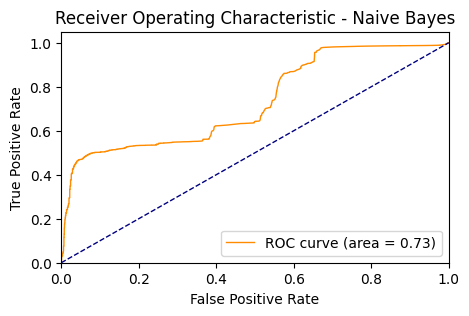

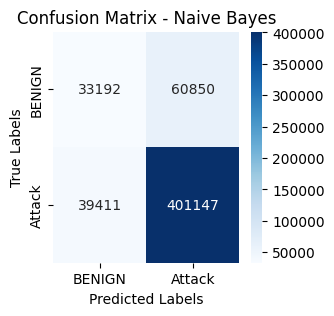

all_data        Naive Bayes      0.81         0.66         0.63         0.64         1.614        0.7307      


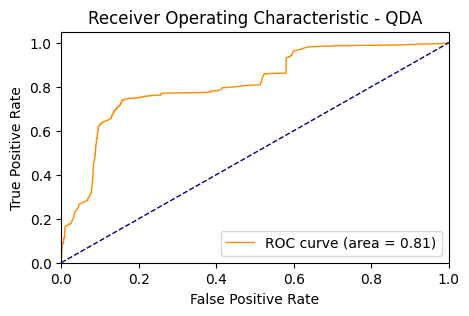

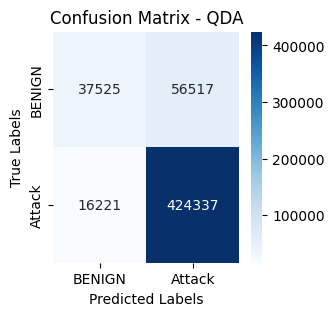

all_data        QDA              0.86         0.79         0.68         0.71         2.4016       0.8143      


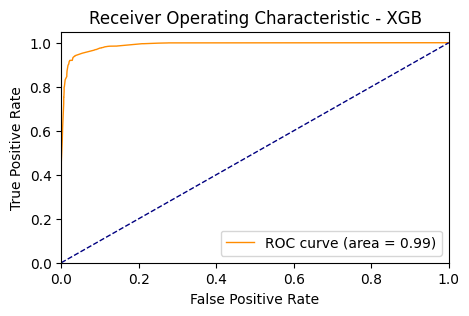

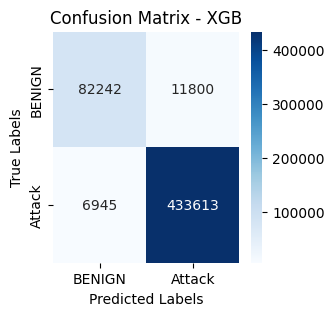

all_data        XGB              0.96         0.95         0.93         0.94         92.8896      0.9898      


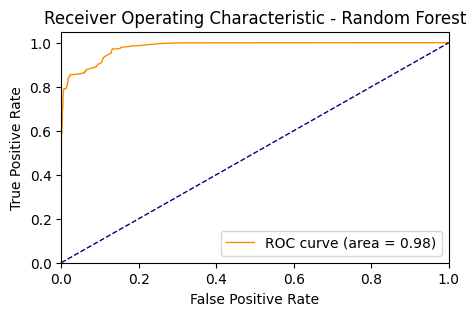

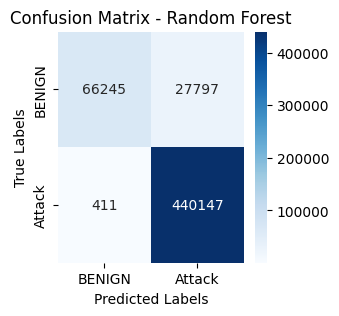

all_data        Random Forest    0.95         0.97         0.85         0.9          50.8875      0.9813      


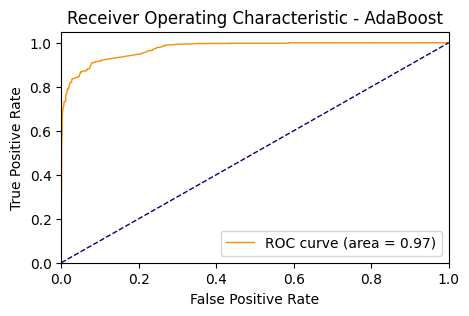

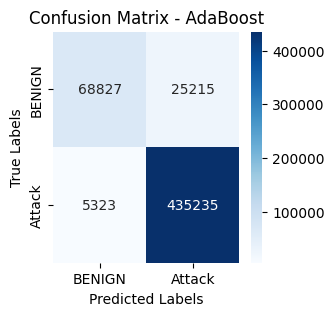

all_data        AdaBoost         0.94         0.94         0.86         0.89         94.7349      0.9739      


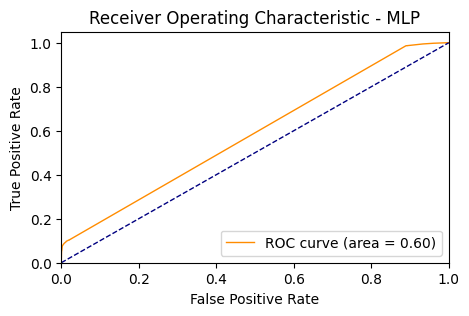

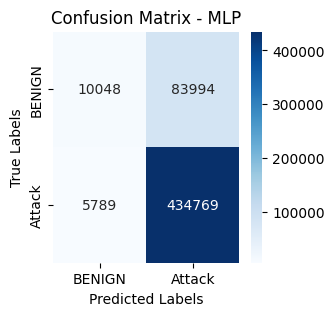

all_data        MLP              0.83         0.75         0.54         0.53         202.4012     0.5957      


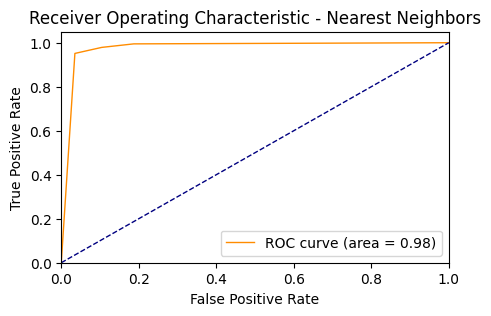

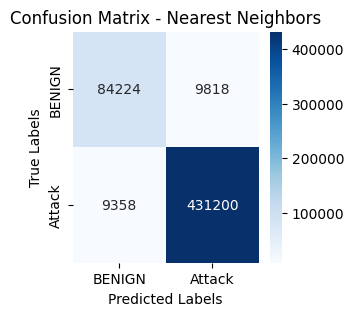

all_data        Nearest Neighbors  0.96         0.94         0.94         0.94         127.8095     0.9759      
Best model (XGB) saved as best_model.pkl
Total operation time: =  6077.845090866089 seconds


In [4]:
csv_files=["all_data.csv"]# CSV files names: #The names of the dataset files (csv_files).
path=""
repetition=10


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"XGB":XGBClassifier(n_estimators=100, learning_rate=0.01, objective='binary:logistic'),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=100, max_features=2, n_jobs=-1),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3, n_jobs=-1)}



#list of all columns to be imported
# the 7 features with the highest importance weight selected by the file "04_2_feature_selection_for_attack_files.py" are used here. (+ Label Feature)

features={"all_data":["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
     "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total","Label"]}

seconds=time.time()#time stamp for all processing time



best_model = {
    'algorithm': None,
    'roc_auc': 0.0,  # Initialize with a low value
    'model': None,    # Store the trained model object
}

for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-15s %-15s  %-12s %-12s %-12s %-12s %-12s %-12s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time", "roc_auc"))# print output header   
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        roc_auc = []
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).

            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            
            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )
            
            y_scores = clf.predict_proba(X_test)[:, 1]  # Use predicted probabilities for positive class
            fpr, tpr, _ = roc_curve(y_test, y_scores)
            roc_auc.append(auc(fpr, tpr))
            
        # Plot ROC curve
        plt.figure(figsize=(5,3))
        plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % np.mean(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic - ' + str(ii))
        plt.legend(loc="lower right")
        plt.show()
        
        cm = confusion_matrix(y_test, predict)

        # Plot confusion matrix
        plt.figure(figsize=(3, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["BENIGN", "Attack"], yticklabels=["BENIGN", "Attack"])
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title(f"Confusion Matrix - {ii}")
        plt.show()


            
        print ('%-15s %-15s  %-12s %-12s %-12s %-12s %-12s %-12s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4)),str(round(np.mean(roc_auc),4))))#the result of the ten repetitions is printed on the screen.
        if np.mean(roc_auc) > best_model['roc_auc']:
            best_model['algorithm'] = ii
            best_model['roc_auc'] = np.mean(roc_auc)
            best_model['model'] = clf
        

## serializing model

In [16]:
if best_model['model'] is not None:
    best_model_filename = 'best_model.pkl'
    with open(best_model_filename, 'wb') as model_file:
        joblib.dump(best_model['model'], model_file)
    print(f'Best model ({best_model["algorithm"]}) saved as {best_model_filename}')
else:
    print('No best model found.')

print("Total operation time: = ",time.time()- seconds ,"seconds")


Best model (XGB) saved as best_model.pkl
Total operation time: =  7305.242307424545 seconds
